## 2 Feature Selection

This focuses on caveats/justifications of the feature selection process that will yield the most relevant features to undergo the feature transformation process.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

pd.pandas.set_option('display.max_columns', None)

> Rows that have missing target labels are dropped at this point and a new dataset is utilised

In [13]:
df = pd.read_csv('life_expectancy.csv')
print(df.shape)
df.head()

(2928, 22)


,Country,Year,Status,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,Bmi,Under_Five_Deaths,Polio,Total_Expenditure,Diphtheria,Hiv/Aids,Gdp,Population,Thinness_1to19,Thinness_5to9,Income_Composition,Schooling,Life_Expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


In [18]:
missing_num = [var for var in df.columns if df[var].isnull().sum() > 0 and df[var].dtype != 'O']
df[missing_num].isnull().mean().sort_values(ascending=False)

Population            0.219945
Hepatitis_B           0.188866
Gdp                   0.151298
Total_Expenditure     0.077186
Alcohol               0.065915
Schooling             0.054645
Income_Composition    0.054645
Bmi                   0.010929
Thinness_1to19        0.010929
Thinness_5to9         0.010929
Polio                 0.006489
Diphtheria            0.006489
dtype: float64

In [19]:
num_var = [var for var in df.columns if df[var].dtype != 'O' and var != 'Life_Expectancy']
print(len(num_var))
num_var

19


['Year',
 'Adult_Mortality',
 'Infant_Deaths',
 'Alcohol',
 'Percentage_Expenditure',
 'Hepatitis_B',
 'Measles',
 'Bmi',
 'Under_Five_Deaths',
 'Polio',
 'Total_Expenditure',
 'Diphtheria',
 'Hiv/Aids',
 'Gdp',
 'Population',
 'Thinness_1to19',
 'Thinness_5to9',
 'Income_Composition',
 'Schooling']

In [20]:
cat_var = [var for var in df.columns if var not in num_var and var != 'Life_Expectancy']
cat_var

['Country', 'Status']

### Variable Inflation Factor (VIF)

In [21]:
X = df[num_var].dropna()
X_const = add_constant(X)

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i + 1) for i in range(X.shape[1])]
print(vif.sort_values(by="VIF", ascending=False))

                   Feature         VIF
2            Infant_Deaths  213.609554
8        Under_Five_Deaths  203.591034
13                     Gdp   13.649710
4   Percentage_Expenditure   12.904426
15          Thinness_1to19    7.606109
16           Thinness_5to9    7.584832
18               Schooling    3.538093
17      Income_Composition    3.028945
11              Diphtheria    2.094307
3                  Alcohol    2.067310
14              Population    1.943421
1          Adult_Mortality    1.809171
7                      Bmi    1.802986
9                    Polio    1.722414
5              Hepatitis_B    1.680406
6                  Measles    1.516630
12                Hiv/Aids    1.500870
0                     Year    1.157920
10       Total_Expenditure    1.124370


> Features that both have high VIF >5 and are also highly correlated with each other (based on the correlation heatmap), indicates a multicollinearity issue. The feature less correlated with the target/less feature importance will be dropped to keep the other feature.

In [46]:
top_VIF = vif[vif['VIF'] > 5]
top_VIF

,Feature,VIF
2,Infant_Deaths,213.609554
4,Percentage_Expenditure,12.904426
8,Under_Five_Deaths,203.591034
13,Gdp,13.649710
15,Thinness_1to19,7.606109
16,Thinness_5to9,7.584832


In [47]:
VIF_list = top_VIF['Feature'].tolist()
top_VIF = df[[var for var in df.columns if var in VIF_list] + ['Life_Expectancy']]
corr_to_target = top_VIF.corr()['Life_Expectancy'].sort_values(ascending=False)
corr_to_target

Life_Expectancy           1.000000
Gdp                       0.461455
Percentage_Expenditure    0.381864
Infant_Deaths            -0.196557
Under_Five_Deaths        -0.222529
Thinness_5to9            -0.471584
Thinness_1to19           -0.477183
Name: Life_Expectancy, dtype: float64

> All of these 6 features have low linear/non-linear relationship with the target and they will be evaluated based on their feature importance to remove the redundancy and multicollinearity. 

### Feature Importance

> Choosing `feature_importances_` with RandomForestRegressor is justified in this step as some features has nonlinear correlation to target but high correlation to each other. RandomForest handles multicollinearity, so by using feature importance, the most predictive among collinear features are kept.

> Choosing other feature selection methods like LassoCV or SFS (sequential feature selection) can be infeasible since it does not handle nonlinearity that well/sensitive to feature scaling, especially if the final model to be used is not linear-based. Processing every feature at this stage just to accommodate the feature selection method is practically inefficient.Using RFE (recursive feature elimination) might remove useful features than expected since it needs a definite number of features to keep.

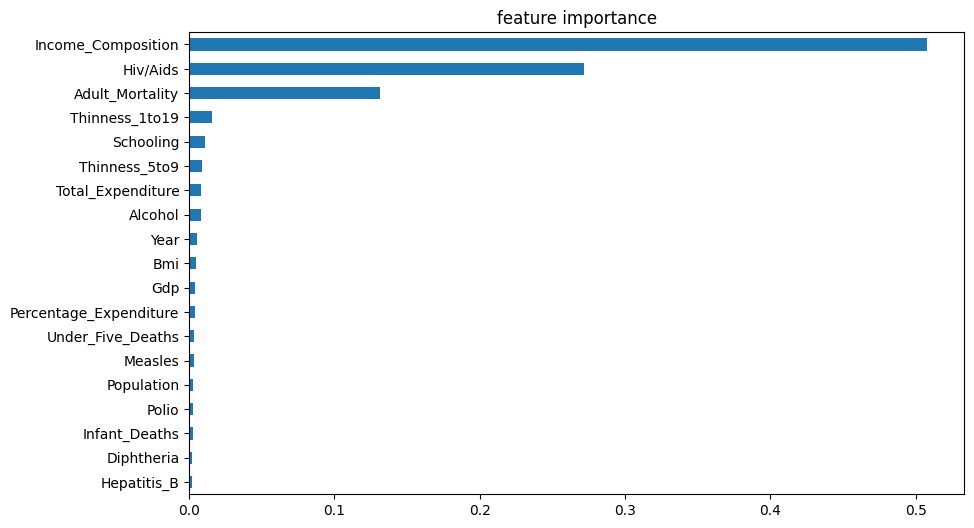

In [117]:
X = pd.concat([df[num_var], df['Life_Expectancy']], axis=1)
X = X.dropna(subset=num_var)
y = X['Life_Expectancy']
X = X.drop(columns=['Life_Expectancy'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,6), title='feature importance')
plt.show()

Based on the VIF ranking and feature importance score, some features can be dropped since they have very high VIF and very low feature importance.

> `Under_Five_Deaths` can be safely dropped and keep `Infant_Deaths` instead, which is more intuitive.

> `GDP` can be kept instead of `Percentage_Expenditure` since it is redundant. `GDP` is also easier to interpret.

> `Thinness_1to19` has slightly broader age range and is more reasonable to keep than `Thinness_5to9`.

For features that have low importance, a more cautious approach is to consider SHAP values/Partial Dependence Plots (PDPs)/Permutation Importance for interpretability. Simply removing these features can result in information loss because of over pruning which is unreasonable.

### Permutation Importance

In [118]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
permut = pd.Series(result.importances_mean, index=X.columns)
permut.sort_values(ascending=False)

Income_Composition        0.353209
Adult_Mortality           0.209535
Hiv/Aids                  0.132807
Thinness_1to19            0.046502
Thinness_5to9             0.009860
Alcohol                   0.008570
Schooling                 0.008046
Year                      0.006428
Total_Expenditure         0.004873
Under_Five_Deaths         0.002952
Infant_Deaths             0.002517
Bmi                       0.002487
Gdp                       0.002151
Measles                   0.001572
Polio                     0.001279
Percentage_Expenditure    0.001113
Diphtheria                0.000851
Population                0.000827
Hepatitis_B               0.000378
dtype: float64

> Features that have very low value <0.005 are safe to drop since these can be just noise, shuffling these barely affects the performance

### SHAP (SHapley Additive exPlanations)

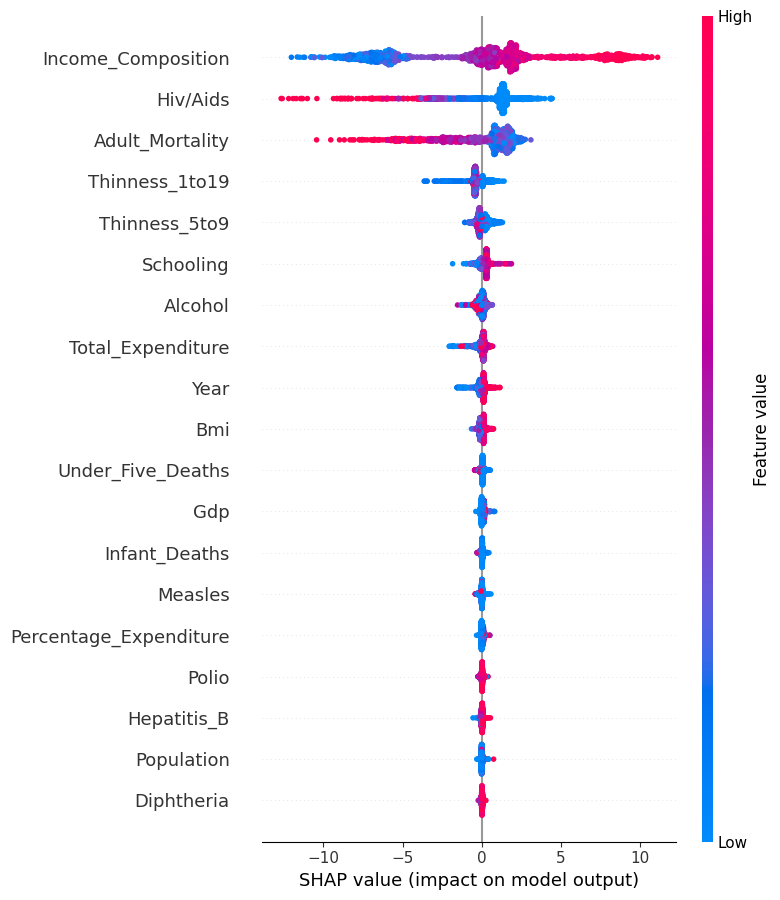

In [120]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

> There are a lot of features that has very minimal effect to the model overall

### PDP (Partial Dependence Plot)

c:\Users\zyrvs\Desktop\test\venv\lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


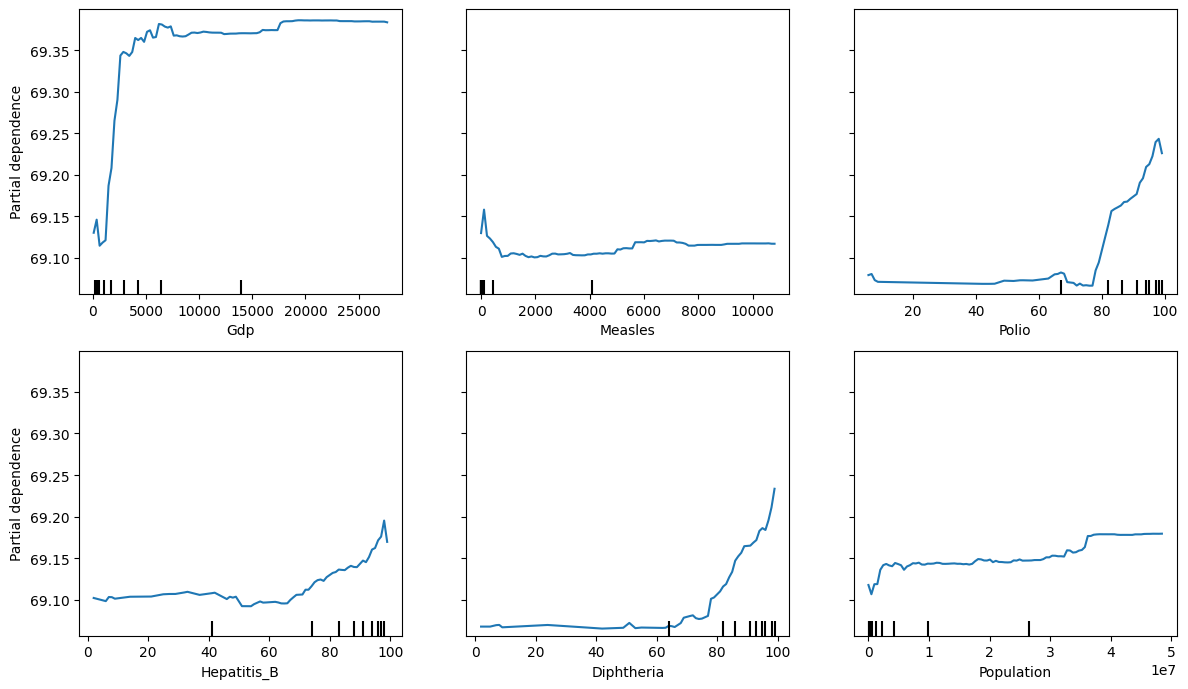

In [121]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

columns = ['Gdp', 'Measles', 'Polio', 'Hepatitis_B', 'Diphtheria', 'Population']

fig, ax = plt.subplots(figsize=(12, 7))
PartialDependenceDisplay.from_estimator(model, X_test, columns, ax=ax, kind='average', grid_resolution=100)
plt.tight_layout()
plt.show()

> This confirms the features with very low importance have weak marginal effects. 

> Features like `Population`, `Hepatitis_B`, `Measles` can be dropped.  
> - `Population` - 22%: High missing data percentage, low impact/importance, low correlation to target, flat PDP 
> - `Hepatitis_B` - 19%: High missing data percentage, low impact/importance, low correlation target
> - `Measles`: low impact/importance, low correlation to target, flat PDP

> Processing these features just introduces noise. Imputing values can flatten the variance and dilute the patterns and even if data was available, there is no guarantee that processing will rescue unimportant features.

> A final check for SHAP/PDP/permutation importance after preprocessing every feature is reasonable, and if new features are useful, a fine-tuning is considered however it is beyond the scope of this project.

In [129]:
drop_features = ['Under_Five_Deaths', 
                 'Percentage_Expenditure', 
                 'Thinness_5to9',
                 'Measles',
                 'Population',
                 'Hepatitis_B']

In [132]:
sample = df.drop(columns=drop_features, axis=1)
sample.head()

,Country,Year,Status,Adult_Mortality,Infant_Deaths,Alcohol,Bmi,Polio,Total_Expenditure,Diphtheria,Hiv/Aids,Gdp,Thinness_1to19,Income_Composition,Schooling,Life_Expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,19.1,6.0,8.16,65.0,0.1,584.259210,17.2,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,18.6,58.0,8.18,62.0,0.1,612.696514,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,18.1,62.0,8.13,64.0,0.1,631.744976,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,17.6,67.0,8.52,67.0,0.1,669.959000,17.9,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,17.2,68.0,7.87,68.0,0.1,63.537231,18.2,0.454,9.5,59.2


In [ ]:
#sample.to_csv('Life_Expectancy_Final.csv', index=False)